In [10]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import math
import ephem
from datetime import datetime, time, timedelta
from math import pi, cos, sin
from scipy import optimize
from joblib import Parallel, delayed
from mpl_toolkits.basemap import Basemap

%run diurnal_utils.py

# Notebook for exploring local CMIP6 data downloaded with `cmip6_downloader.py`

In [71]:
path_to_cmip_dirs = '/export/data1/cchristo/cmip6_clouds/download_from_source/'
save_figs_dir = '/home/cchristo/proj_tapio/figs/diurnal_cycle_figs/gfdl_cm4_2000_2010_clouds/'
save_output_dir = '/export/data1/cchristo/diurnal_analysis_results/'



In [12]:
model_list = os.listdir(path_to_cmip_dirs)
print(model_list)
path_to_cmip_files = path_to_cmip_dirs + 'GFDL-CM4/'
file_list = os.listdir(path_to_cmip_files)
for file in file_list: print(file)

['GFDL-CM4', 'CNRM-CM5', 'GFDL-ESM4', 'IPSL-CM6A']
clt_3hr_GFDL-CM4_historical_r1i1p1f1_gr1_200001010130-201412312230.nc
clt_3hr_GFDL-CM4_historical_r1i1p1f1_gr1_196001010130-197912312230.nc
clt_3hr_GFDL-CM4_historical_r1i1p1f1_gr1_198001010130-199912312230.nc
pr_3hr_GFDL-CM4_historical_r1i1p1f1_gr1_196001010130-197912312230.nc
pr_3hr_GFDL-CM4_historical_r1i1p1f1_gr1_198001010130-199912312230.nc
pr_3hr_GFDL-CM4_historical_r1i1p1f1_gr1_200001010130-201412312230.nc


In [13]:

ds = xr.open_mfdataset(path_to_cmip_files + '*.nc', combine='by_coords')
# ds = xr.open_mfdataset(path_to_cmip_files + '*.nc')

# ds = ds.sel(time=slice('1986','2005'))
ds = ds.sel(time=slice('2000-01-01','2010-01-01'))
# ds = ds.sel(time=slice('2000-06-01','2011-06-01'))
ds = ds.sel(lat= slice(-60, 60))

## Compute Local Solar Time

# compute local solar time with ephem

In [7]:
test = ds.isel(time = -1)
lon_mesh, lat_mesh = np.meshgrid(ds['lon'].values, ds['lat'].values)
utc_time = datetime(2020, 5, 9, 12, 0, 0)
long = -118.2437

res = calc_solar_time(utc_time, long)
res

3.0

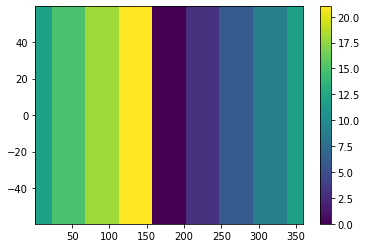

In [8]:
# plt.imshow(lon_mesh)
# plt.colorbar()
lst_grid = calc_solar_time(utc_time, lon_mesh)
plt.pcolormesh(ds['lon'].values, ds['lat'].values, lst_grid)
plt.colorbar()

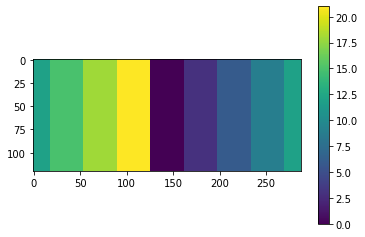

In [9]:
lst_grid = calc_solar_time(utc_time, lon_mesh)
plt.imshow(lst_grid)
plt.colorbar()

In [30]:
lon_mesh, lat_mesh = np.meshgrid(ds['lon'].values, ds['lat'].values)
ds_seasons = ds.groupby('time.season')

mu_season = {}
sigma_season = {}

for season_i, season_ds in ds_seasons:
    if season_i != 'DJF':
        continue
    print(season_i)
    lst_da = compute_lst_array(season_ds, lon_mesh = lon_mesh, lat_mesh = lat_mesh)
    lst_array = lst_da.values
    lst_array[lst_array == 0] = 24
    field_season_array = season_ds['clt'].values

    field_season_mean = field_season_array.mean(axis = 0)
        
    # compute mu_ij
    mu_ij = np.zeros(field_season_array.shape[-2:])
    hour_bins = np.arange(3,27,3)
    f_bar_ks = {}
    for hour_i in tqdm(hour_bins):
    #     print(hour_i)
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_ks[hour_i] = f_bar_k
        mu_ij  += f_bar_k

    mu_ij = (1/8)*mu_ij
    mu_season[season_i] = mu_ij
    
    sigma_ij = np.zeros(field_season_array.shape[-2:])
    for hour_i in hour_bins:
    #     print(hour_i)
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        sigma_ij += np.square(f_bar_k - mu_ij)

    sigma_ij = np.sqrt((1/7)*sigma_ij)
    
    sigma_season[season_i] = sigma_ij

  4%|▍         | 32/728 [00:00<00:02, 312.69it/s]

DJF


100%|██████████| 8/8 [00:02<00:00,  3.57it/s]


In [34]:
# compute mu_ij
mu_ij = np.zeros(field_season_array.shape[-2:])
hour_bins = np.arange(3,27,3)
f_bar_ks = {}
for hour_i in tqdm(hour_bins):
#     print(hour_i)
    masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

    # mean for a given season, LST
    f_bar_k = np.nanmean(masked_field, axis = 0)
    f_bar_ks[hour_i] = f_bar_k
    mu_ij  += f_bar_k
    
mu_ij = (1/8)*mu_ij

100%|██████████| 8/8 [00:55<00:00,  6.99s/it]


In [18]:
# compute sigma_ij

sigma_ij = np.zeros(field_season_array.shape[-2:])
for hour_i in tqdm(hour_bins):
#     print(hour_i)
    masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

    # mean for a given season, LST
    f_bar_k = np.nanmean(masked_field, axis = 0)
    sigma_ij += np.square(f_bar_k - mu_ij)
    
sigma_ij = np.sqrt((1/7)*sigma_ij)

100%|██████████| 8/8 [00:46<00:00,  5.82s/it]


100%|██████████| 8/8 [00:00<00:00, 4692.93it/s]


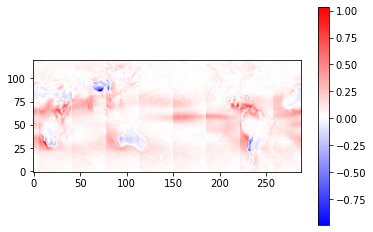

In [167]:
# compute c_ij 
# f_bar_ks
tau = 24
# c_ij = np.zeros(field_season_array.shape[-2:])
sum_p_ij = np.sum(list(f_bar_ks.values()), axis = 0)
first_iter = True
for hour_i in tqdm(f_bar_ks):
    p_ij = np.divide(f_bar_ks[hour_i],sum_p_ij)
    if first_iter:
        c_ij =  p_ij*np.exp(1j*2*np.pi*hour_i/tau)
        first_iter = False
    else:
        c_ij +=  p_ij*np.exp(1j*2*np.pi*hour_i/tau)
    
c_ij = (tau/2/np.pi)*c_ij.imag

plt.imshow(c_ij, origin = 'lower', cmap = plt.get_cmap('bwr'))
# plt.imshow(f_bar_ks[3], origin = 'lower', cmap = plt.get_cmap('bwr'))
plt.colorbar()

# Fit diurnal cloud cycle with sin fit

In [ ]:
params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[2, 2])

# Look at mean timeseries of clouds over a location

In [73]:
# Perform Cos fit over whole grid
time_resolution_hours = 1
field_id = 'clt'


hour_bins = np.arange(time_resolution_hours, 24 + time_resolution_hours, time_resolution_hours)

lon_mesh, lat_mesh = np.meshgrid(ds['lon'].values, ds['lat'].values)
ds_seasons = ds.groupby('time.season')

mu_season = {}
sigma_season = {}
ampl_season = {}
phase_season = {}

for season_i, season_ds in ds_seasons:
#     if season_i != 'DJF':
#         break
    print(season_i)
    lst_da = compute_lst_array(season_ds, 
                               bin_interval = time_resolution_hours,
                               bin_bool = True, 
                               lon_mesh = lon_mesh, 
                               lat_mesh = lat_mesh,
                               field_id = field_id)
    lst_array = lst_da.values
    lst_array[lst_array == 0] = 24
    field_season_array = season_ds[field_id].values

    field_season_mean = field_season_array.mean(axis = 0)
        
    # compute mu_ij
    mu_ij = np.zeros(field_season_array.shape[-2:])
    
    f_bar_ks = {}
    for hour_i in tqdm(hour_bins):
    #     print(hour_i)
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_k[np.isnan(f_bar_k)] = 0
        f_bar_ks[hour_i] = f_bar_k
        mu_ij  += f_bar_k
    hour_means = np.stack(list(f_bar_ks.values()))
    
    mu_ij = (1/len(hour_bins))*mu_ij
    mu_season[season_i] = mu_ij
    

    res = cos_fit_grid(field_season_array, lst_array, hour_means, hour_bins)
    ampl_season[season_i], phase_season[season_i] = res[0], res[1]
    
    sigma_ij = np.zeros(field_season_array.shape[-2:])
    for hour_i in hour_bins:
    #     print(hour_i)
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_k[np.isnan(f_bar_k)] = 0
        sigma_ij += np.square(f_bar_k - mu_ij)

    sigma_ij = np.sqrt((1/(len(hour_bins) - 1))*sigma_ij)
    
    sigma_season[season_i] = sigma_ij


  4%|▍         | 32/728 [00:00<00:02, 319.67it/s]

DJF


100%|██████████| 120/120 [02:46<00:00,  1.39s/it]
/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
  4%|▎         | 27/736 [00:00<00:02, 268.37it/s]

JJA


100%|██████████| 120/120 [03:06<00:00,  1.56s/it]
/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
  4%|▍         | 32/736 [00:00<00:02, 315.90it/s]

MAM


100%|██████████| 120/120 [03:02<00:00,  1.52s/it]
/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
  4%|▍         | 31/728 [00:00<00:02, 304.44it/s]

SON


100%|██████████| 120/120 [02:59<00:00,  1.49s/it]
/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice


In [14]:
mu_season, sigma_season, ampl_season, phase_season = diurnal_analysis(ds, 
                                                                      field_id = 'clt', 
                                                                      grid_time_resolution_hours=3,
                                                                      time_resolution_hours = 1)

  0%|          | 27/7208 [00:00<00:26, 269.35it/s]

DJF


100%|██████████| 7208/7208 [00:26<00:00, 268.65it/s]
/home/cchristo/proj_tapio/diurnal_utils.py:269: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


  0%|          | 28/7360 [00:00<00:26, 276.04it/s]

Finished Cos Fit
JJA


100%|██████████| 7360/7360 [00:27<00:00, 270.21it/s]
/home/cchristo/proj_tapio/diurnal_utils.py:269: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


  0%|          | 26/7360 [00:00<00:28, 255.96it/s]

Finished Cos Fit
MAM


100%|██████████| 7360/7360 [00:27<00:00, 264.11it/s]
/home/cchristo/proj_tapio/diurnal_utils.py:269: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


  0%|          | 26/7280 [00:00<00:28, 257.02it/s]

Finished Cos Fit
SON


100%|██████████| 7280/7280 [00:27<00:00, 261.30it/s]
/home/cchristo/proj_tapio/diurnal_utils.py:269: RuntimeWarning: Mean of empty slice
  f_bar_k = np.nanmean(masked_field, axis = 0)
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


100%|██████████| 120/120 [08:09<00:00,  4.08s/it]

Finished Cos Fit


In [128]:
field_id = 'clt'
grid_time_resolution_hours = 3
time_resolution_hours = 1



hour_bins = np.arange(time_resolution_hours, 24 + time_resolution_hours, time_resolution_hours)
grid_hour_bins = np.arange(grid_time_resolution_hours, 24 + grid_time_resolution_hours, grid_time_resolution_hours)
    
lon_mesh, lat_mesh = np.meshgrid(ds['lon'].values, ds['lat'].values)
ds_seasons = ds.groupby('time.season')

mu_season = {}
sigma_season = {}
ampl_season = {}
phase_season = {}

for season_i, season_ds in ds_seasons:
    if season_i != 'DJF':
        break
    print(season_i)
#     lst_da = compute_lst_array(season_ds, 
#                                bin_interval = 3, # time_resolution_hours,
#                                bin_bool = True, 
#                                lon_mesh = lon_mesh, 
#                                lat_mesh = lat_mesh,
#                                field_id = field_id)
#     lst_array = lst_da.values
#     lst_array[lst_array == 0] = 24
#     field_season_array = season_ds[field_id].values

#     field_season_mean = field_season_array.mean(axis = 0)

#     # compute mu_ij
# #         mu_ij = np.zeros(field_season_array.shape[-2:])
#     mu_ij = np.zeros(field_season_array.shape[-2:])
# #         sigma_ij = np.zeros((len(hour_bins),) + field_season_array.shape[-2:])

#     f_bar_ks = {}
#     for hour_i in grid_hour_bins:
#         masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

#         # mean for a given season, LST
#         f_bar_k = np.nanmean(masked_field, axis = 0)
# #             f_bar_k[np.isnan(f_bar_k)] = 0
#         f_bar_ks[hour_i] = f_bar_k
#         mu_ij  += f_bar_k
# #             mu_ij_[ii,:,:] = f_bar_k
# #         hour_means = np.stack(list(f_bar_ks.values()))
# #             plt.imshow(f_bar_k, origin = 'lower')
# #             plt.show()

#     mu_ij = (1/len(grid_hour_bins))*mu_ij
# #         mu_ij = (1/8)*mu_ij
#     mu_season[season_i] = mu_ij

#     sigma_ij = np.zeros(field_season_array.shape[-2:])
#     for hour_i in grid_hour_bins:
#         masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

#         # mean for a given season, LST
#         f_bar_k = np.nanmean(masked_field, axis = 0)
# #             f_bar_k[np.isnan(f_bar_k)] = 0
#         sigma_ij += np.square(f_bar_k - mu_ij)

#     sigma_ij = np.sqrt((1/(len(grid_hour_bins) - 1))*sigma_ij)
# #         sigma_ij = np.sqrt((1/7)*sigma_ij)
# #         sigma_ij = np.nanstd(sigma_ij, axis = 0)

#     sigma_season[season_i] = sigma_ij

    lst_da = compute_lst_array(season_ds, 
                               bin_interval = time_resolution_hours,
                               bin_bool = True, 
                               lon_mesh = lon_mesh, 
                               lat_mesh = lat_mesh,
                               field_id = field_id)
    lst_array = lst_da.values
    lst_array[lst_array == 0] = 24
    field_season_array = season_ds[field_id].values

    field_season_mean = field_season_array.mean(axis = 0)

    # compute hourly grid means needed for cos fit
    f_bar_ks = {}
    for ii in range(len(hour_bins)):
        hour_i = hour_bins[ii]
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
#         f_bar_k[np.isnan(f_bar_k)] = 0
        f_bar_ks[hour_i] = f_bar_k

    hour_means = np.stack(list(f_bar_ks.values()))

    print('Performing Cos Fit')
#     res = cos_fit_grid(field_season_array, lst_array, hour_means, hour_bins)
    res = cos_fit_grid_average(hour_means, hour_bins)
    print('Finished Cos Fit')
    ampl_season[season_i], phase_season[season_i] = res[0], res[1]

  4%|▎         | 26/728 [00:00<00:02, 256.40it/s]

DJF


100%|██████████| 728/728 [00:02<00:00, 258.64it/s]
/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
  0%|          | 0/120 [00:00<?, ?it/s]

Performing Cos Fit


100%|██████████| 120/120 [02:50<00:00,  1.42s/it]

Finished Cos Fit


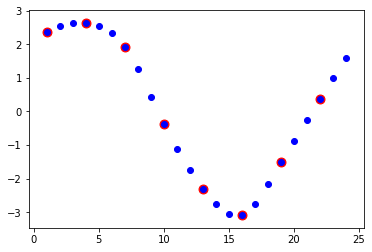

In [121]:
ts_loc = hour_means[:,0, 0]
plt.scatter(hour_bins, ts_loc - np.nanmean(ts_loc), s = 80, c = 'r')
plt.scatter(hour_bins, ts_loc_mean_sub_interp, c = 'b')

In [123]:
# ts_loc_mean_sub


In [124]:
from scipy import interpolate

ts_loc = hour_means[:,0, 0]
ts_loc_mean_sub = ts_loc - np.nanmean(ts_loc)
non_nan_inds = np.where(np.isfinite(ts_loc_mean_sub))

f = interpolate.interp1d(hour_bins[non_nan_inds], 
                         ts_loc_mean_sub[non_nan_inds], 
                         kind = 'quadratic',
                         fill_value="extrapolate")

ts_loc_mean_sub_interp = f(hour_bins)

params, params_covariance = optimize.curve_fit(cos_func, 
                                               hour_bins, 
                                               ts_loc_mean_sub_interp,
                                               bounds = (0,24),
                                               p0=[10, 
                                                   hour_bins[np.argmax(ts_loc)]],
                                               maxfev=10000)

In [125]:
# type(ds['time'][0].item()) == cftime._cftime.DatetimeNoLeap
params

array([2.86108605, 3.49462477])

In [47]:
mu_test = {ff:3*ii for ff, ii in mu_season.items()}
sigma_test = {ff:3*ii for ff, ii in sigma_season.items()}
# mu_season = {}

In [31]:
# mu_test
# mu_season.items()
# mu_test
save_figs_dir

'/home/cchristo/proj_tapio/figs/diurnal_cycle_figs/gfdl_cm4_2000_2010'

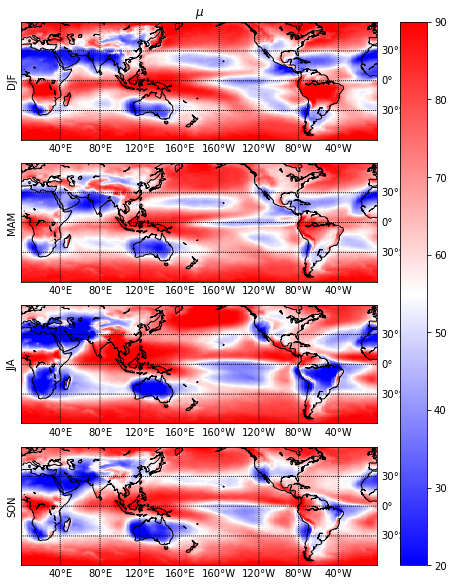

In [33]:
# plt.figure(figsize = (6,10))
make_four_panel(mu_season , 
                lats = ds['lat'].values, 
                lons = ds['lon'].values,
                vmin = 20, vmax = 90, 
                cmap = plt.get_cmap('bwr'),
                title = r'$\mu$',
#                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path = None)
                save_fig_path= save_figs_dir + 'GFDL_CM4_means.png')



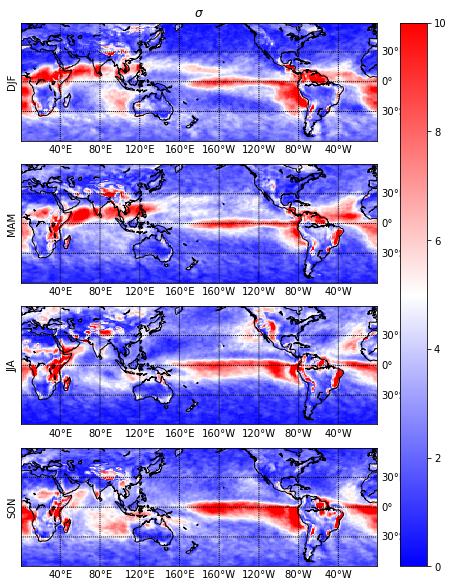

In [34]:
make_four_panel(sigma_season , 
                lats = ds['lat'].values, 
                lons = ds['lon'].values,
                vmin = 0, vmax = 10, 
                cmap = plt.get_cmap('bwr'),
                title = r'$\sigma$',
#                 axis = plt.axis([220, 300, 10, 50]), 
                save_fig_path= save_figs_dir + 'GFDL_CM4_stds.png')



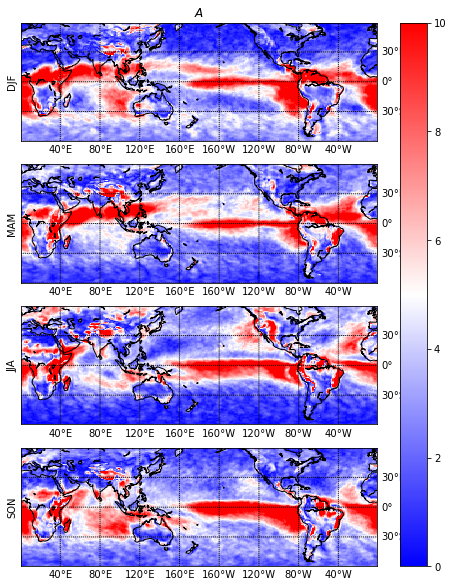

In [41]:
# plt.figure(figsize = (6,10))
make_four_panel(ampl_season , 
                lats = ds['lat'].values, 
                lons = ds['lon'].values,
                vmin = 0, vmax = 10, 
                cmap = plt.get_cmap('bwr'),
                title = r'$A$',
#                 axis = plt.axis([220, 300, 10, 50]), 
                save_fig_path= save_figs_dir + 'GFDL_CM4_ampl.png')



In [53]:
np.zeros((30,) + (10,20)).shape

(30, 10, 20)

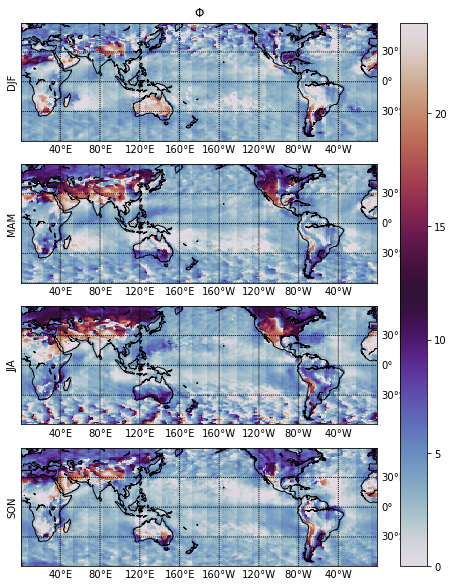

In [39]:
# plt.figure(figsize = (6,10))

make_four_panel(phase_season , 
                lats = ds['lat'].values, 
                lons = ds['lon'].values,
                vmin = 0, vmax = 24, 
                cmap = plt.get_cmap('twilight'),
                title = r'$\Phi$',
#                 axis = plt.axis([220, 300, 10, 50]))
                save_fig_path= save_figs_dir + 'GFDL_CM4_phase.png')


In [45]:
season_dict.values()

NameError: name 'season_dict' is not defined

In [66]:
out_ds = xr.Dataset()
out_ds['mu_season'] = make_da_from_dict(mu_season, ds)
out_ds['sigma_season'] = make_da_from_dict(sigma_season,ds)
out_ds['ampl_season'] = make_da_from_dict(ampl_season, ds)
out_ds['phase_season'] = make_da_from_dict(phase_season,ds)

In [72]:
out_ds.to_netcdf(save_output_dir + 'gfdl_cm4_2000_2010_clouds.nc')